In [1]:
# Install Java and Spark
!apt-get install openjdk-11-jdk -y
!wget https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvzf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Crystallization Analysis") \
    .getOrCreate()


Exception: Unable to find py4j in /content/spark-3.5.1-bin-hadoop3/python, your SPARK_HOME may not be configured correctly

In [4]:
# Install Java
!apt-get install openjdk-11-jdk -y

# Download Spark from a working mirror
!wget https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract Spark
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz

# Install findspark
!pip install -q findspark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.27+6~us1-0ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
--2025-06-27 06:52:56--  https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388341449 (370M) [application/x-gzip]
Saving to: ‘spark-3.4.1-bin-hadoop3.tgz’

spark-3.4.1-bin-had 100%[===================>] 370.35M  9.86MB/s    in 40s     

2025-06-27 06:53:37 (9.32 MB/s) - ‘spark-3.4.1-bin-hadoop3.tgz’ saved [388341449/388341449]

spark-3.4.1-bin-hadoop3/
spark-3.4.1-bin-hadoop3/R/
spark-3.4.1-bin-hadoop3/R/lib/
spark-3.4.1-bin-hadoop3/R/lib/sparkr.zip
spark-3.4.1-bin-hadoop3/R/lib/SparkR/
spark-3.4.1

In [5]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"


**Initialize SparkSession**

In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Crystallization Analysis") \
    .getOrCreate()


**Load the Dataset into a Spark DataFrame**

In [8]:
df = spark.read.csv("/content/processed_data.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- pdb_id: string (nullable = true)
 |-- pe_index: string (nullable = true)
 |-- sequence: string (nullable = true)
 |-- poly_type: string (nullable = true)
 |-- struct_method: string (nullable = true)
 |-- crystal_method: string (nullable = true)
 |-- ph: string (nullable = true)
 |-- temp: string (nullable = true)
 |-- pdbx_details: string (nullable = true)
 |-- deposit_date: string (nullable = true)
 |-- revision_date: timestamp (nullable = true)

+------+--------+--------------------+---------+-----------------+--------------+---+----+--------------------+--------------------+-------------------+
|pdb_id|pe_index|            sequence|poly_type|    struct_method|crystal_method| ph|temp|        pdbx_details|        deposit_date|      revision_date|
+------+--------+--------------------+---------+-----------------+--------------+---+----+--------------------+--------------------+-------------------+
|  5IQ6|       1|MDVIGERIKRIKEEHNS...|  Protein|X-RAY DIFFRACTION|  SITTING-DRO

***Dataset Before Cleaning***

In [16]:
print("Before cleaning:", df.count())

Before cleaning: 15453


**Check Missing Values**

In [21]:
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+------+--------+--------+---------+-------------+--------------+----+----+------------+------------+-------------+
|pdb_id|pe_index|sequence|poly_type|struct_method|crystal_method|  ph|temp|pdbx_details|deposit_date|revision_date|
+------+--------+--------+---------+-------------+--------------+----+----+------------+------------+-------------+
|    40|     780|     917|     1567|         1736|          1823|3017|3475|        2057|        3116|         3122|
+------+--------+--------+---------+-------------+--------------+----+----+------------+------------+-------------+



In [22]:
df_clean_all = df.dropna()


**Dataset After Cleaning**

In [23]:
# Count rows before and after
print("Original rows:", df.count())
print("After removing all nulls:", df_clean_all.count())

# Check if any nulls remain
from pyspark.sql.functions import col, when, count

df_clean_all.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Original rows: 15453
After removing all nulls: 10028
+------+--------+--------+---------+-------------+--------------+---+----+------------+------------+-------------+
|pdb_id|pe_index|sequence|poly_type|struct_method|crystal_method| ph|temp|pdbx_details|deposit_date|revision_date|
+------+--------+--------+---------+-------------+--------------+---+----+------------+------------+-------------+
|     0|       0|       0|        0|            0|             0|  0|   0|           0|           0|            0|
+------+--------+--------+---------+-------------+--------------+---+----+------------+------------+-------------+



In [24]:

print("After cleaning:", df_clean.count())


After cleaning: 10925


**Most Common Crystallization Methods**

In [26]:
df_clean = df.filter(df.crystal_method.isNotNull())


In [27]:
from pyspark.sql.functions import col

df_clean = df_clean.filter(~col("crystal_method").rlike(r"\d{4}-\d{2}-\d{2}"))


In [28]:
df_clean.groupBy("crystal_method").count().orderBy("count", ascending=False).show()


+------------------+-----+
|    crystal_method|count|
+------------------+-----+
|      SITTING-DROP| 6781|
|      HANGING-DROP| 5794|
|             BATCH|  428|
|       EVAPORATION|  110|
|          DIALYSIS|   82|
|               LCP|   72|
|  LIQUID-DIFFUSION|   30|
|       SMALL-TUBES|   27|
| COUNTER-DIFFUSION|   14|
|           IN-CELL|   14|
|   VAPOR DIFFUSION|    6|
|      SITTING DROP|    5|
|      HANGING DROP|    5|
|           SEEDING|    4|
|          12      |    2|
|                 5|    2|
| temperature 295K"|    2|
| temperature 293K"|    2|
| temperature 298K"|    1|
|         UNDER-OIL|    1|
+------------------+-----+
only showing top 20 rows



**Average pH and Temp by Crystal Method**

In [35]:
from pyspark.sql.functions import col

df_casted = df.withColumn("ph", col("ph").cast("double")) \
              .withColumn("temp", col("temp").cast("double"))


In [36]:
df_casted.groupBy("crystal_method") \
    .avg("ph", "temp") \
    .orderBy("avg(temp)", ascending=False) \
    .show()


+--------------------+------------------+------------------+
|      crystal_method|           avg(ph)|         avg(temp)|
+--------------------+------------------+------------------+
|             IN-CELL|               8.7|299.92857142857144|
|           SLOW-COOL|              null|             298.0|
|    LIQUID-DIFFUSION| 6.703333333333333|            296.81|
|                null| 7.643749999999999|            295.75|
|             SEEDING|             5.475| 294.6666666666667|
|           UNDER-OIL|               7.0|             293.0|
|         EVAPORATION| 7.143434343434342|292.84909090909105|
|               BATCH| 6.688273972602733| 292.7121779859485|
|        HANGING-DROP| 6.787596261682221| 291.3671157894728|
|        SITTING-DROP| 6.851733118971031|  290.599265785609|
|   COUNTER-DIFFUSION| 6.918181818181818|290.32142857142856|
|                 LCP|6.3323529411764685|290.26180555555555|
|         SMALL-TUBES|             6.504| 288.6666666666667|
|            DIALYSIS| 7

**Filter out rows where crystal_method is null**

In [37]:
df_clean = df_casted.filter(col("crystal_method").isNotNull())


**Remove rows where crystal_method contains dates or wrong patterns**

In [38]:
# Remove values that look like dates or improperly formatted strings
from pyspark.sql.functions import col

df_clean = df_clean.filter(~col("crystal_method").rlike(r"\d{4}-\d{2}-\d{2}"))  # remove ISO date strings
df_clean = df_clean.filter(~col("crystal_method").rlike(r"pH\s*\d"))           # remove weird pH strings
df_clean = df_clean.filter(~col("crystal_method").rlike(r"temperature\s*\d"))  # remove weird temp strings


**Re-Run Aggregation**

In [39]:
df_clean.groupBy("crystal_method") \
    .avg("ph", "temp") \
    .orderBy("avg(temp)", ascending=False) \
    .show(truncate=False)


+---------------------+------------------+------------------+
|crystal_method       |avg(ph)           |avg(temp)         |
+---------------------+------------------+------------------+
|IN-CELL              |8.7               |299.92857142857144|
|SLOW-COOL            |null              |298.0             |
|LIQUID-DIFFUSION     |6.703333333333333 |296.81            |
|SEEDING              |5.475             |294.6666666666667 |
|UNDER-OIL            |7.0               |293.0             |
|EVAPORATION          |7.143434343434342 |292.84909090909105|
|BATCH                |6.688273972602733 |292.7121779859485 |
|HANGING-DROP         |6.787596261682221 |291.3671157894728 |
|SITTING-DROP         |6.851733118971031 |290.599265785609  |
|COUNTER-DIFFUSION    |6.918181818181818 |290.32142857142856|
|LCP                  |6.3323529411764685|290.26180555555555|
|SMALL-TUBES          |6.504             |288.6666666666667 |
|DIALYSIS             |7.131645569620244 |288.4024390243902 |
| SITTIN

**Trim Whitespace + Uppercase for Consistency**

In [40]:
from pyspark.sql.functions import trim, upper

df_cleaned = df_casted.withColumn("crystal_method", trim(upper(col("crystal_method"))))


**Filter Out Invalid Method Names**

In [41]:
valid_methods = [
    "SITTING-DROP", "HANGING-DROP", "BATCH", "EVAPORATION", "DIALYSIS",
    "LCP", "LIQUID-DIFFUSION", "SMALL-TUBES", "COUNTER-DIFFUSION",
    "IN-CELL", "SLOW-COOL", "SEEDING", "UNDER-OIL"
]


In [46]:
# Then filter
df_final = df_cleaned.filter(col("crystal_method").isin(valid_methods))


In [47]:
df_final = df_cleaned.filter(
    (col("ph").isNotNull()) &
    (col("crystal_method").isin(valid_methods))
)


**Re-Run Aggregation**

In [48]:
df_final.groupBy("crystal_method") \
    .avg("ph", "temp") \
    .orderBy("avg(temp)", ascending=False) \
    .show(truncate=False)


+-----------------+------------------+------------------+
|crystal_method   |avg(ph)           |avg(temp)         |
+-----------------+------------------+------------------+
|IN-CELL          |8.7               |298.0             |
|LIQUID-DIFFUSION |6.703333333333333 |296.81            |
|SEEDING          |5.475             |294.6666666666667 |
|EVAPORATION      |7.143434343434342 |293.2666666666668 |
|UNDER-OIL        |7.0               |293.0             |
|BATCH            |6.688273972602733 |292.9233516483516 |
|HANGING-DROP     |6.787596261682221 |291.35151905935845|
|COUNTER-DIFFUSION|6.918181818181818 |290.95454545454544|
|SITTING-DROP     |6.851733118971031 |290.64583755316994|
|LCP              |6.3323529411764685|290.0985294117647 |
|DIALYSIS         |7.131645569620244 |288.3544303797468 |
|SMALL-TUBES      |6.504             |288.3             |
+-----------------+------------------+------------------+



**Top N crystallization methods by frequency:**

In [49]:
df_final.groupBy("crystal_method").count().orderBy("count", ascending=False).show()


+-----------------+-----+
|   crystal_method|count|
+-----------------+-----+
|     SITTING-DROP| 6220|
|     HANGING-DROP| 5350|
|            BATCH|  365|
|      EVAPORATION|   99|
|         DIALYSIS|   79|
|              LCP|   68|
| LIQUID-DIFFUSION|   30|
|      SMALL-TUBES|   25|
|COUNTER-DIFFUSION|   11|
|          SEEDING|    4|
|          IN-CELL|    2|
|        UNDER-OIL|    1|
+-----------------+-----+



# Visualization

In [51]:
# aggregated Spark DataFrame
agg_df = df_final.groupBy("crystal_method") \
    .avg("ph", "temp") \
    .orderBy("avg(temp)", ascending=False)

# Converting this to  to Pandas
agg_pd = agg_df.toPandas()


**Bar Graph – Frequency of Crystallization Methods**

/tmp/ipython-input-54-3680987913.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_pd, x="crystal_method", y="avg(temp)", palette="Blues_d")


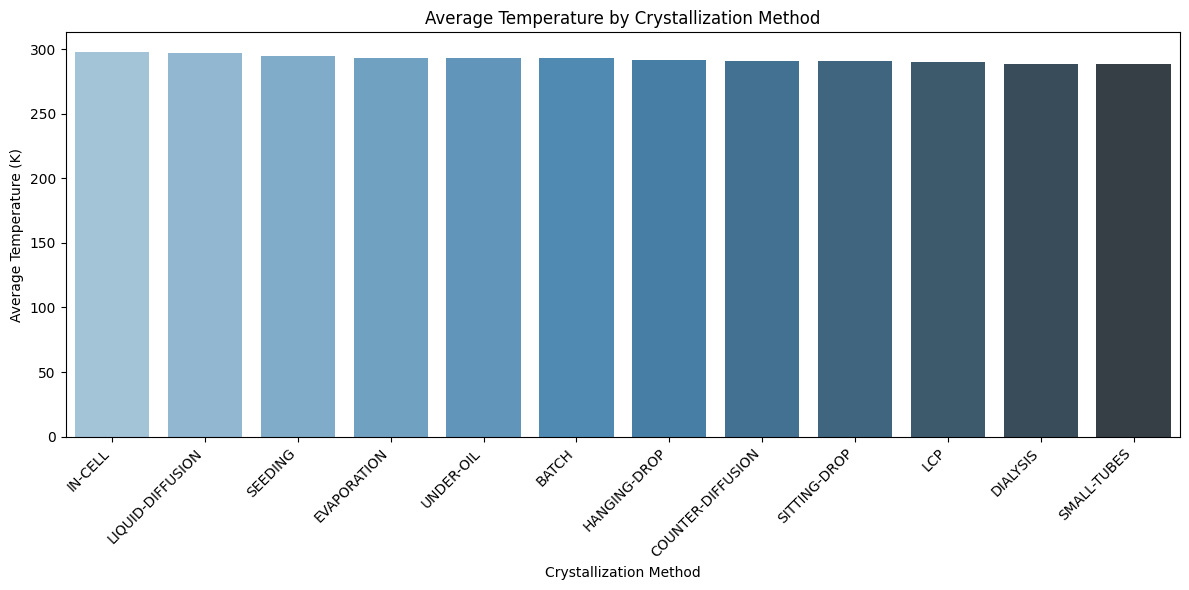

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=agg_pd, x="crystal_method", y="avg(temp)", palette="Blues_d")
plt.xticks(rotation=45, ha='right')
plt.title("Average Temperature by Crystallization Method")
plt.xlabel("Crystallization Method")
plt.ylabel("Average Temperature (K)")
plt.tight_layout()
plt.show()


X-axis: Crystallization Method

Y-axis: Average Temperature (K)

 **Average Temperature by Crystallization Method:**

**-->The height of each bar shows how hot or cold the method is on average.**

**-->The darker the blue, the lower the temperature**

**Average pH by Crystallization Method**

/tmp/ipython-input-60-748928915.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_pd, x="crystal_method", y="avg(ph)", palette="Greens_d")


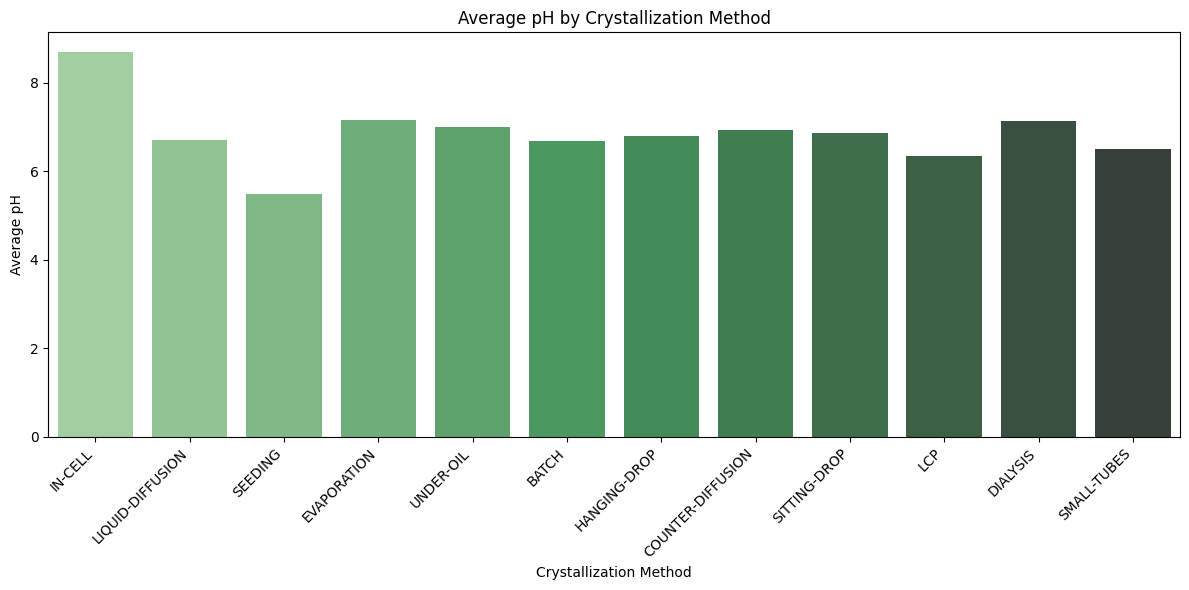

In [60]:
plt.figure(figsize=(12, 6))
sns.barplot(data=agg_pd, x="crystal_method", y="avg(ph)", palette="Greens_d")
plt.xticks(rotation=45, ha='right')
plt.title("Average pH by Crystallization Method")
plt.xlabel("Crystallization Method")
plt.ylabel("Average pH")
plt.tight_layout()
plt.show()


X-axis: type of crystallization method.

Y-axis: average pH level (acidity/basicity).



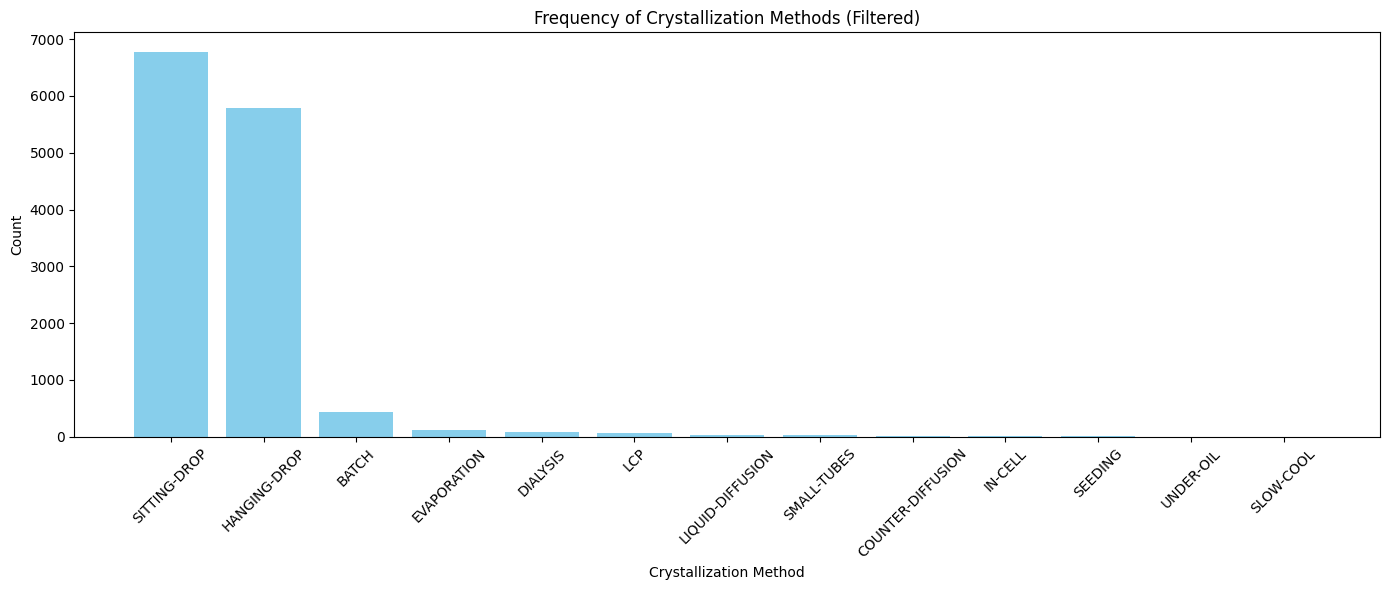

In [56]:
# List of valid crystallization methods to include
valid_methods = [
    "SITTING-DROP", "HANGING-DROP", "BATCH", "EVAPORATION", "DIALYSIS",
    "LCP", "LIQUID-DIFFUSION", "SMALL-TUBES", "COUNTER-DIFFUSION",
    "IN-CELL", "SLOW-COOL", "SEEDING", "UNDER-OIL"
]

# Convert Spark DataFrame to Pandas DataFrame
filtered_df = df.filter(df["crystal_method"].isin(valid_methods)) \
                .groupBy("crystal_method").count().toPandas()

# Sort by count for a nicer plot
filtered_df = filtered_df.sort_values("count", ascending=False)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.bar(filtered_df["crystal_method"], filtered_df["count"], color='skyblue')
plt.xticks(rotation=45)
plt.title("Frequency of Crystallization Methods (Filtered)")
plt.xlabel("Crystallization Method")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


X-axis: Different crystallization methods (like HANGING-DROP, IN-CELL, etc.)

Y-axis: Number of entries (how many times each method was used)

**Scatter Plot – pH vs Temperature (Correlation)**

Each point shows the average pH and temperature for one crystallization method.



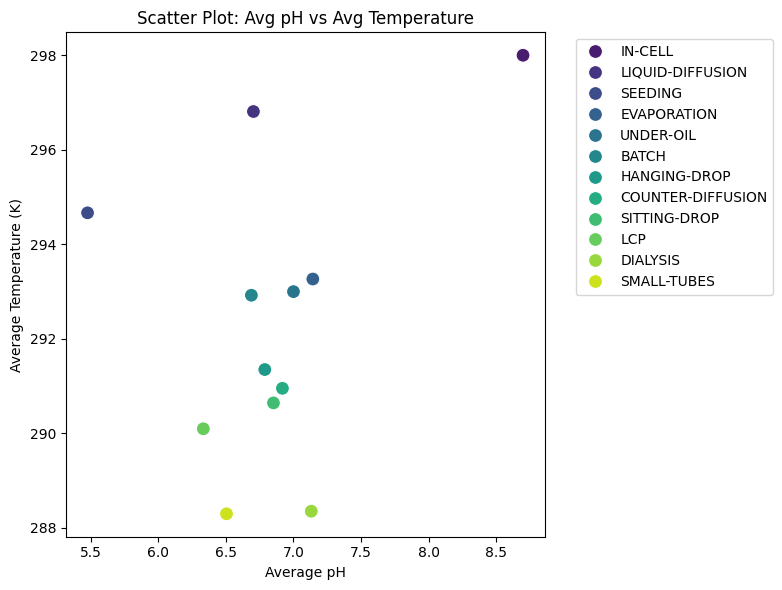

In [59]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=agg_pd, x="avg(ph)", y="avg(temp)", hue="crystal_method", palette="viridis", s=100)
plt.title("Scatter Plot: Avg pH vs Avg Temperature")
plt.xlabel("Average pH")
plt.ylabel("Average Temperature (K)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


X-axis: Average pH

Y-axis: Average temperature (K)

Color: Represents the method name.

/tmp/ipython-input-53-748928915.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_pd, x="crystal_method", y="avg(ph)", palette="Greens_d")


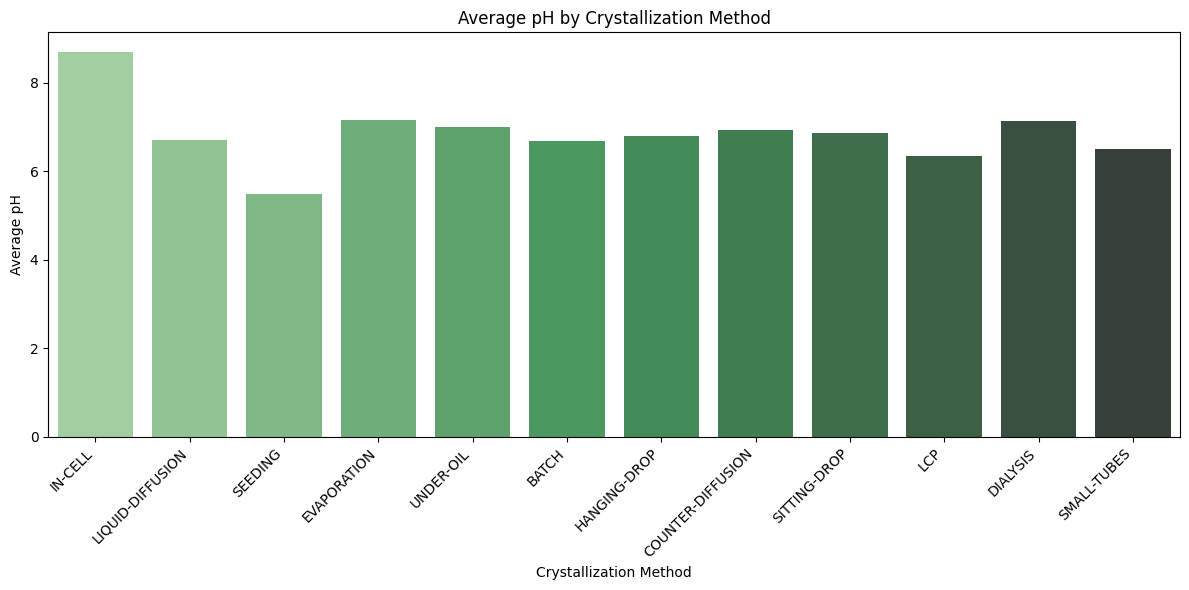